In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

# File I/O + create/manage run_folders

In [2]:
# MPI rows/cols
Ncols = 4
Nrows = 1
Nsolenoids = 2

In [ ]:
def read_phases(linesplit_list):
    sol_flag = 0
    rf_flag = 0
    gun_phase = 0
    linac_phases = []
    sol_strengths = []
    for element in linesplit_list:
        if len(element) < 4:
            continue
        if element[3] == '112':
            if rf_flag == 0:
                gun_phase = float(element[7])
            else:
                linac_phases.append(float(element[7]))
            rf_flag += 1
        if element[3] == '3':
            if sol_flag < Nsolenoids:
                sol_strengths.append(float(element[5]))
                sol_flag += 1
    
    return gun_phase, linac_phases, sol_strengths

def write_new_input_file(outfname,gun_phase,sol_strengths,linac_phases,linesplit_list,charge=1.0,gun_amp=61.33):
    rf_flag = 0
    sol_flag = 0
    linesplit_list[8][0] = str(1.3*charge)
    with open(outfname,'w') as fout:
        for element in linesplit_list:
            if (len(element) >= 4):
                if element[3] == '112':
                    if rf_flag == 0:
                        element[7] = str(gun_phase)
                        element[5] = str(gun_amp/61.33*28.835)
                    else:
                        element[7] = str(linac_phases[rf_flag - 1])
                    rf_flag += 1
                if element[3] == '3':
                    if sol_flag < Nsolenoids:
                        if sol_flag == 0 or sol_flag == 1:
                            element[5] = str(sol_strengths[0])
                        else:
                            element[5] = str(sol_strengths[sol_flag])
                        sol_flag += 1

            fout.write(" ".join(element)+"\n")

def create_new_run_folder(foldername,gun_phase,sol_strengths,linac_phases,linesplit_list,charge,gun_amp):
    if not os.path.isdir(foldername):
        os.mkdir(foldername)
    os.system('cp ./Input/* '+foldername+'/')
    Nbunch = int(linesplit_list[1][-1])
    linesplit_list[2][1] = str(int(int(linesplit_list[2][1])/Nbunch))
    write_new_input_file(foldername+"/ImpactT.in",gun_phase,sol_strengths,linac_phases,linesplit_list,charge,gun_amp)
    if Nbunch > 1:
        print("Creating More Input Files")
        fnames = [foldername+"/ImpactT"+str(i)+".in" for i in range(2,Nbunch+1)]
        for name in fnames:
            #print("cp "+foldername+"/ImpactT.in "+" ".join(fnames))
            os.system("cp "+foldername+"/ImpactT.in "+name)

def run_folder(foldername,Nranks):
    os.system('cd '+foldername+' && mpirun -n '+str(Nranks)+' ./ImpactTexe-mpi > out.log')
    #

def clear_run_folder(foldername):
    if os.path.isdir(foldername):
        os.system('rm '+foldername+'/fort*')

def impact_to_superfish(filename):
    """to convert the """

    # turn each column in the file to a list

### IMPACT-T to superfish
The coordinates of particle used inside the IMPACT-T are dimensionless variables:
$$x, \, p_x/mc,\, y,\, p_y /mc, \,z, \,p_z /mc$$
the momentum $p_k = \gamma\beta_k$ for $k = x$, $y$, $z$, $\beta_k = v_k/c$, $v_k$ is the velocity in each direction and $c$ is the speed of light.

I think I'll look at 

In [4]:
# with open("ImpactT_model.in",'r') as fin: - previous
with open("Input/ImpactT.in",'r') as fin:
    lines = fin.readlines()
linesplit_list = []
for line in lines:
    if line.split()[0] == '!' or line.split()[0][0] == '!':
        continue
    else:
        linesplit_list.append(line.split())
gun_phase, linac_phases, sol_strengths = read_phases(linesplit_list)
linesplit_list[0][0] = str(Ncols)
linesplit_list[0][1] = str(Nrows)
Nbunch = int(linesplit_list[1][-1])
#gun_phase  = 136
print(gun_phase,linac_phases)
print(sol_strengths)

100.24459 []
[8.70857453e-05, 8.70857453e-05]


In [5]:
x = np.linspace(0,4,5)
print(x[3:])

[3. 4.]


In [6]:
def L2NormToFlat(zprof):
    res = np.histogram(zprof,bins=31)
    hist2 = np.ones(len(res[0]))*np.max(res[0])
    return np.linalg.norm(res[0]-hist2)/np.linalg.norm(hist2)

# Genetic Algorithm based Optimization using pymoo

In [7]:
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize

In [8]:
PhaseDiff = 60
#linac_phases -= 45*np.ones(len(linac_phases))
GunPhaseDiff = 5
charge_low = 1.0
charge_high = 10.0
gun_amp_low = 10
gun_amp_high = 70
sol_strength_max = 1e-3
Npart = int(linesplit_list[2][1])


class Zone1Problem(ElementwiseProblem):

    def __init__(self,foldername,linesplit_list):
        super().__init__(n_var=3,
                         n_obj=2,
                         n_ieq_constr=1,
                         xl=np.array([gun_phase-GunPhaseDiff,charge_low,gun_amp_low]),
                         #,linac_phases[0]-PhaseDiff,linac_phases[1]-PhaseDiff,linac_phases[2]-PhaseDiff,linac_phases[3]-PhaseDiff,linac_phases[4]-PhaseDiff,linac_phases[5]-PhaseDiff]),
                         xu=np.array([gun_phase+GunPhaseDiff,charge_high,gun_amp_high]))
                        #,linac_phases[0]+PhaseDiff,linac_phases[1]+PhaseDiff,linac_phases[2]+PhaseDiff,linac_phases[3]+PhaseDiff,linac_phases[4]+PhaseDiff,linac_phases[5]+PhaseDiff]))
        self.foldername = foldername
        self.linesplit_list = linesplit_list
    
    def _evaluate(self, x, out, *args, **kwargs):
        gun_phase = x[0]
        charge = x[1]
        gun_amp = x[2]
        #sol_strengths = x[1:3]
        #linac_phases = x[1:]

        costs = np.ones(problem.n_obj)
        constraints = np.ones(problem.n_ieq_constr)

        clear_run_folder(self.foldername)
        create_new_run_folder(self.foldername,gun_phase,sol_strengths,linac_phases,linesplit_list,charge,gun_amp)
        run_folder(self.foldername,Nrows*Ncols)

        # Read PS at the end of the simulation
        try:
            LPSYag4 = np.loadtxt(self.foldername+"/fort.50")
        except:
            costs *= 0.0
            constraints *= np.inf
        else:
            if (len(LPSYag4) < 10):
                costs *= 0.0
                constraints *= np.inf
            else:
                costs[0] = 1.0/np.mean(LPSYag4[:,-1])
                if np.isnan(costs[0]):
                    costs *= 0.0
                    constraints *= np.inf
                else:
                    # Calculate Chirp
                    #Lthresh = 100e-12
                    ii = np.where(LPSYag4[:,-1] > 0)
                    costs[1] = len(LPSYag4[ii])
                    #A = np.vstack([LPSYag4[:,-2], np.ones(len(LPSYag4[:,-2]))]).T
                    #m, c = np.linalg.lstsq(A,LPSYag4[:,-1],rcond=None)[0]
                    ii = np.where(LPSYag4[:,-2] == np.max(LPSYag4[:,-2]))[0][0]
                    jj = np.where(LPSYag4[:,-2] == np.min(LPSYag4[:,-2]))[0][0]
                    m2 = (LPSYag4[ii,-1] - LPSYag4[jj,-1])/(np.max(LPSYag4[:,-2])-np.min(LPSYag4[:,-2]))
                    constraints[0] = m2 #m2 + 150 #(m + m2)/2
                    #constraints[0] = Npart - len(LPSYag4[:,-2])
                    #costs[1] = abs(m2+150)

                    #plt.clf()
                    #plt.plot(LPSYag4[:,-2],LPSYag4[:,-1]*0.511,'r.')
                    #plt.grid()
                    #plt.xlabel(r"$z$")
                    #plt.ylabel(r"$p_{z}$")
                    #plt.show()
            
        out["F"] = costs.tolist()
        out["G"] = constraints.tolist()

        print("CURRENT FUNC EVAL") 
        print("Gun Phase:",gun_phase,"LINAC Phases:", linac_phases,"Charge:", charge, "Gun Amp:", gun_amp)
        print("MEAN Energy:",(costs[0])*0.511, "PLost Fraction:", costs[1], "Chirp:",constraints[0])

In [9]:
problem = Zone1Problem("MaximizeLPSMomentumYAG4",linesplit_list)

algorithm = NSGA2(
    pop_size=15,
    n_offsprings=5,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)
termination = get_termination("n_gen", 25)

#res = minimize(problem, algorithm, termination, seed=1, save_history=True, verbose=True)

#X = res.X
#F = res.F

# AWA Gun Simulations

## AWA Gun Superfish Fields

In [10]:
with open("Input/1T1.T7") as fin:
    lines = fin.readlines()
    linesplit = [lines[i].split() for i in range(len(lines))]

In [11]:
Zmin = float(linesplit[0][0])/100
Zmax = float(linesplit[0][1])/100
Nz = int(linesplit[0][2])
freq = float(linesplit[1][0])*1e6
Rmin = float(linesplit[2][0])/100
Rmax = float(linesplit[2][1])/100
Nr = int(linesplit[2][2])

print(Zmin, Zmax, Nz, Rmin, Rmax, Nr)

0.0 0.29270745000000004 300 0.0 0.05 50


In [12]:
E = np.zeros([Nz+1,Nr+1,2])
Emag = np.zeros([Nz+1,Nr+1])
Bt = np.zeros([Nz+1,Nr+1])

linesplitE = linesplit[4::2]
linesplitB = linesplit[5::2]

for ind in range(len(linesplitE)):
    i = ind % (Nz+1)
    j = int(ind / (Nz+1)) - 1
    E[i,j,0] = float(linesplitE[ind][0])*1e6
    E[i,j,1] = float(linesplitE[ind][1])*1e6
    Emag[i,j] = float(linesplitE[ind][2])*1e6
    Bt[i,j] = float(linesplitB[ind][0])*4e-7*np.pi

Text(0.5, 0, '$r$ (mm)')

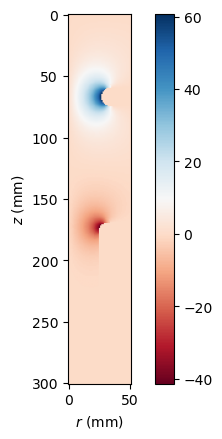

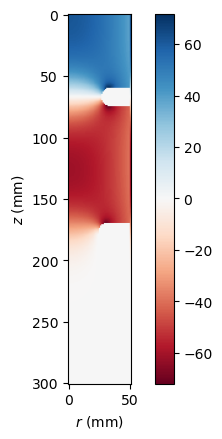

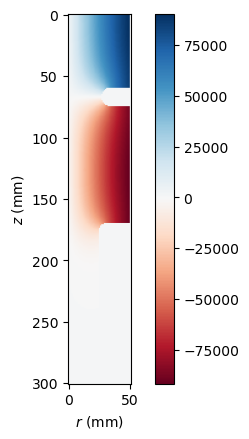

In [13]:
plt.imshow(E[:,:,1]*28.835/1e6,cmap='RdBu')
plt.colorbar()
plt.ylabel(r"$z$ (mm)")
plt.xlabel(r"$r$ (mm)")
plt.figure()
plt.imshow(E[:,:,0]*28.835/1e6,cmap='RdBu')
plt.ylabel(r"$z$ (mm)")
plt.xlabel(r"$r$ (mm)")
plt.colorbar()
plt.savefig(r"Ez_fields_gun.png")
plt.figure()
plt.imshow(Bt[:,:]*28.835/(4e-7*np.pi),cmap='RdBu')
plt.colorbar()
plt.ylabel(r"$z$ (mm)")
plt.xlabel(r"$r$ (mm)")

-29.861944666106112  MV/m is at phi= 119.16000000000003


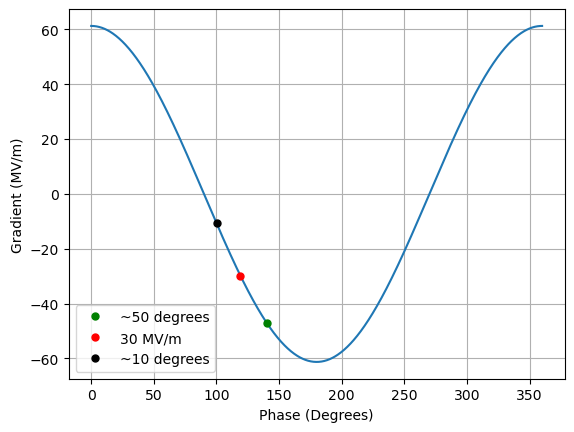

In [14]:
# Gradient near the gun at different phase. Assume t-harmonic with cos(omega*t+\phi)
t = 0
Nphi = 1001
omega = 2*np.pi*freq
phi = np.linspace(0,2*np.pi,Nphi)
#Egrad = np.zeros(Nphi)

Egrad = E[0,0,0]*np.cos(omega*t+phi)/1e6

ii = np.where(abs(Egrad*28.835 + 30) == np.min(abs(Egrad*28.835 + 30)))
print(Egrad[ii[0][0]]*28.835," MV/m is at phi=",phi[ii[0][0]]/np.pi*180)

plt.plot(phi/np.pi*180,Egrad*28.835)
plt.plot(phi[389]/np.pi*180,Egrad[389]*28.835,'o',color='green',markersize=5,label="~50 degrees")
plt.plot(phi[ii]/np.pi*180,Egrad[ii]*28.835,'ro',markersize=5,label="30 MV/m")
plt.plot(phi[278]/np.pi*180,Egrad[278]*28.835,'o',color='black',markersize=5,label="~10 degrees")
plt.xlabel(r"Phase (Degrees)")
plt.ylabel(r"Gradient (MV/m)")
plt.legend()
plt.grid()

In [15]:
phi[389]/np.pi*180

np.float64(140.04000000000002)

The first batch of simulations are at 5 nC, I'm just looking at the Gun scan for transmission and mean energy

In [16]:
x1 = np.loadtxt("Input/partcl.data",skiprows=1)
# x2 = np.loadtxt("Input/partcl2.data",skiprows=1) # dont have the other ones
# x3 = np.loadtxt("Input/partcl3.data",skiprows=1)
# x4 = np.loadtxt("Input/partcl4.data",skiprows=1)

In [17]:
Lz = 3.2e-6

In [18]:
def define_part(Nbunch,charge,Lx,Ly,Lz):
    # 10K parts/nC
    for n in range(Nbunch):
        Npart = int(1e4/Nbunch)
        parts = np.zeros([Npart,6])
        for i in range(Npart):
            flag = False
            while (flag == False):
                x = np.random.uniform(low=-Lx/2,high=Lx/2)
                y = np.random.uniform(low=-Lx/2,high=Lx/2)

                if (np.sqrt(x**2 + y**2) < Lx/2):
                    parts[i,0] = x
                    parts[i,2] = y
                    flag = True
                
        parts[:,4] = np.random.uniform(low=-Lz+n*Lz/Nbunch,high=-Lz+(n+1)*Lz/Nbunch,size=Npart)
        if(n == 0):
            fout = open("./Input/partcl.data","w")
        else:
            fout = open("./Input/partcl"+str(n+1)+".data","w")
        fout.write(str(Npart)+"\n")
        fout.write("0.0 0.0 0.0 0.0 "+str(parts[0,4])+" 1.46717e-03\n")
        for i in range(1,Npart):
            fout.write(str(parts[i,0])+" 0.0 "+str(parts[i,2])+" 0.0 "+str(parts[i,4])+" 1.46717e-03\n")

In [19]:
define_part(2,1.0,1e-2,1e-2,Lz)

In [20]:
Nbunch

1

Simulating  20 MV/m, for 1.0
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 1.0 Gun Amp: 20
MEAN Energy: 0.11377871751809922 PLost Fraction: 10000.0 Chirp: 144.39302061901208


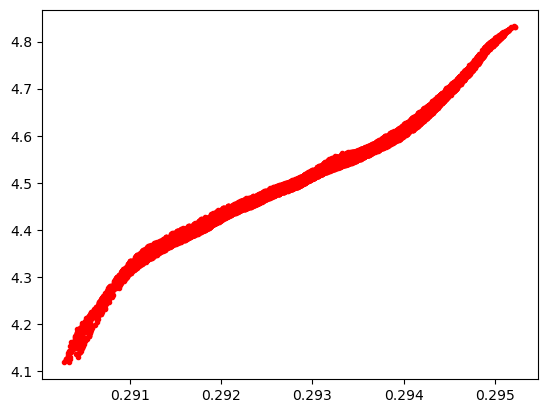

20 : 1.0 : 1.0
Simulating  20 MV/m, for 3.9
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 3.9 Gun Amp: 20
MEAN Energy: 0.11523208165229629 PLost Fraction: 10000.0 Chirp: 103.1373330589267


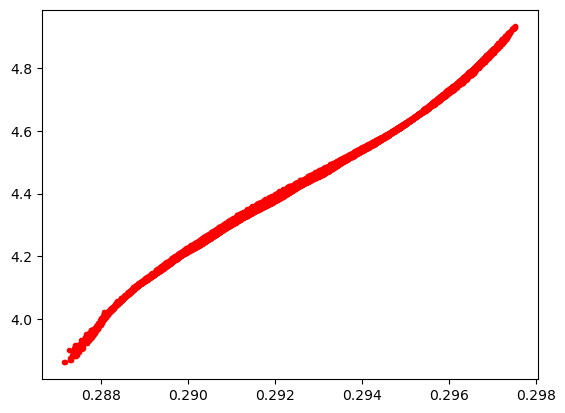

20 : 3.9 : 3.9000000000000004
Simulating  20 MV/m, for 6.8
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 6.8 Gun Amp: 20
MEAN Energy: 0.11713920888072654 PLost Fraction: 10000.0 Chirp: 79.94501209633499


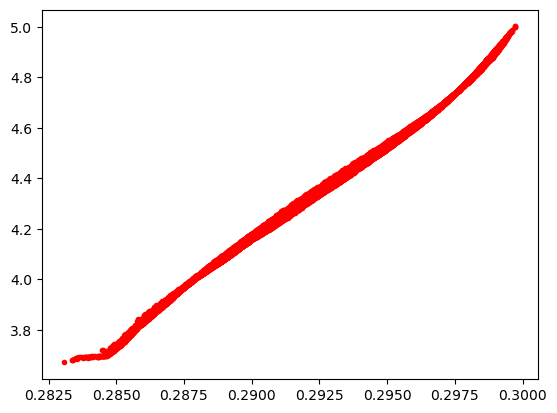

20 : 6.8 : 6.799999999999999
Simulating  20 MV/m, for 9.7
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 9.7 Gun Amp: 20
MEAN Energy: 0.11973558160812307 PLost Fraction: 10000.0 Chirp: 74.55124860177169


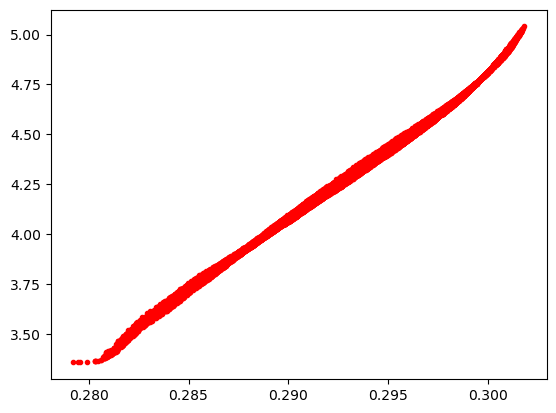

20 : 9.7 : 9.7
Simulating  20 MV/m, for 12.6
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 12.6 Gun Amp: 20
MEAN Energy: 0.12327605048023764 PLost Fraction: 9894.0 Chirp: 72.02833296070713


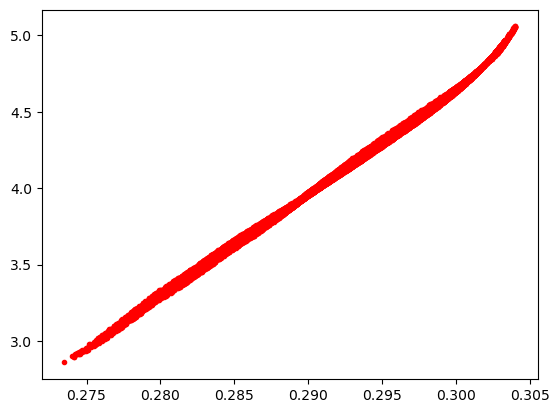

20 : 12.6 : 12.46644
Simulating  20 MV/m, for 15.5
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 15.5 Gun Amp: 20
MEAN Energy: 0.12332654344281525 PLost Fraction: 8286.0 Chirp: 72.95195992192188


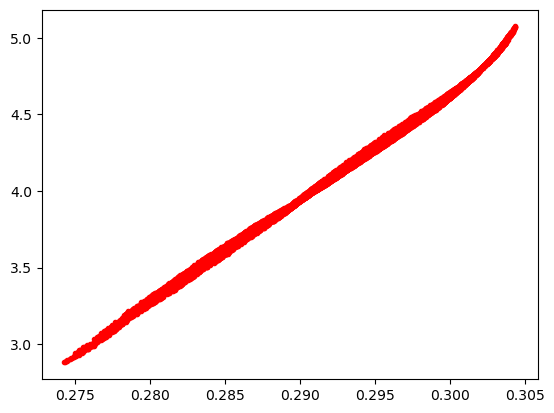

20 : 15.5 : 12.843300000000001
Simulating  20 MV/m, for 18.4
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 18.4 Gun Amp: 20
MEAN Energy: 0.12283953978041201 PLost Fraction: 6934.0 Chirp: 73.11535186073228


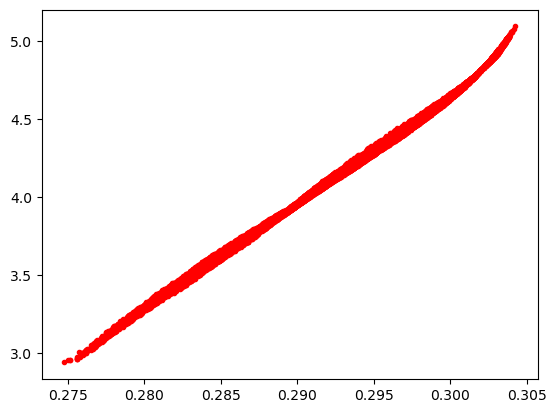

20 : 18.4 : 12.75856
Simulating  20 MV/m, for 21.3
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 21.3 Gun Amp: 20
MEAN Energy: 0.12341854700692433 PLost Fraction: 6199.0 Chirp: 71.46194198023669


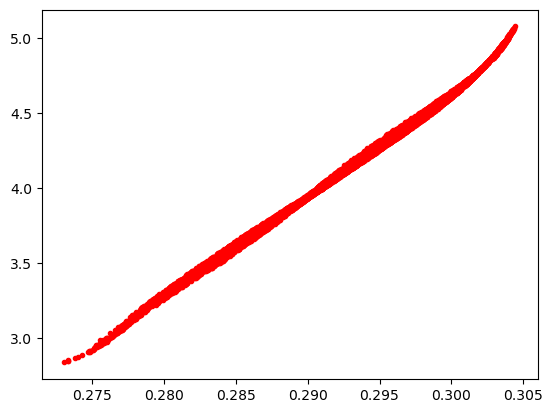

20 : 21.3 : 13.20387
Simulating  20 MV/m, for 24.2
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 24.2 Gun Amp: 20
MEAN Energy: 0.12439478537446932 PLost Fraction: 5746.0 Chirp: 71.28311106714337


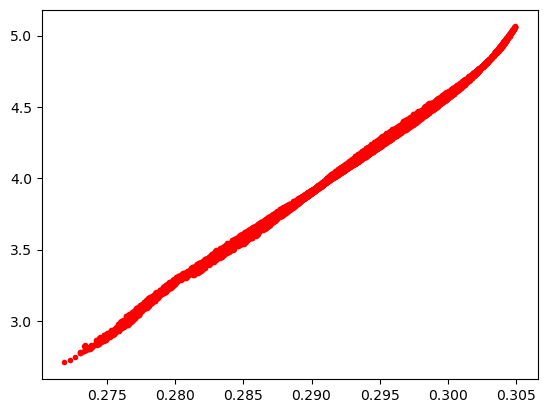

20 : 24.2 : 13.90532
Simulating  20 MV/m, for 27.099999999999998
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 27.099999999999998 Gun Amp: 20
MEAN Energy: 0.12463051301570079 PLost Fraction: 5215.0 Chirp: 70.21340402335964


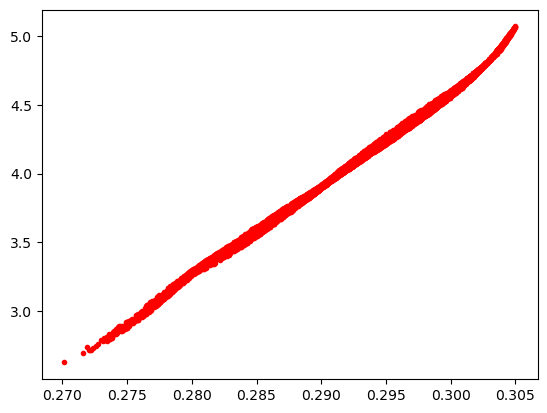

20 : 27.099999999999998 : 14.132649999999998
Simulating  20 MV/m, for 30.0
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 30.0 Gun Amp: 20
MEAN Energy: 0.1248569820111806 PLost Fraction: 4775.0 Chirp: 70.36257609204341


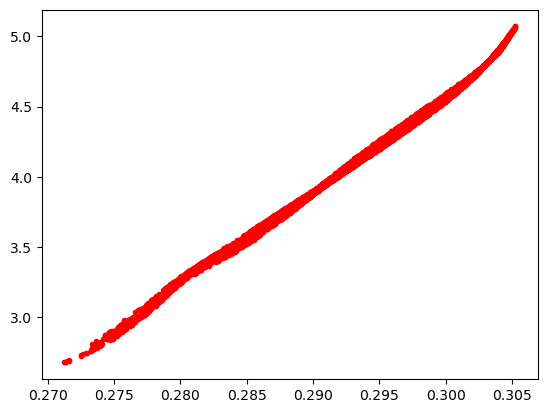

20 : 30.0 : 14.325000000000001
Simulating  30 MV/m, for 1.0
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 1.0 Gun Amp: 30
MEAN Energy: 0.07455576875332659 PLost Fraction: 10000.0 Chirp: 117.44863692988643


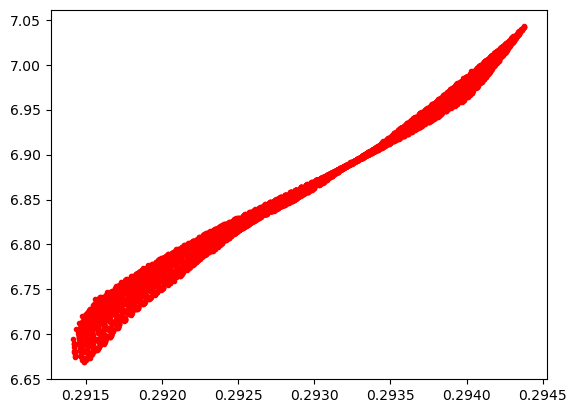

30 : 1.0 : 1.0
Simulating  30 MV/m, for 3.9
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 3.9 Gun Amp: 30
MEAN Energy: 0.07478145344528497 PLost Fraction: 10000.0 Chirp: 144.90156299000714


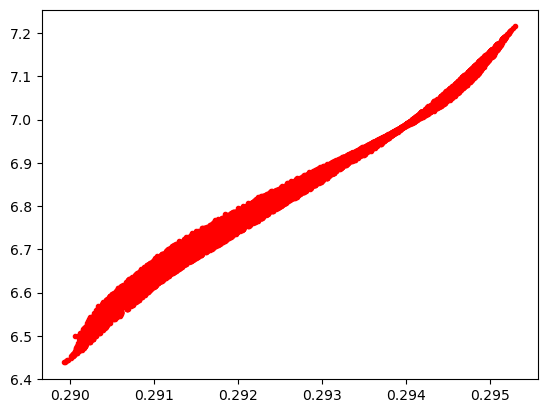

30 : 3.9 : 3.9000000000000004
Simulating  30 MV/m, for 6.8
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 6.8 Gun Amp: 30
MEAN Energy: 0.07504107281319529 PLost Fraction: 10000.0 Chirp: 130.1075567991694


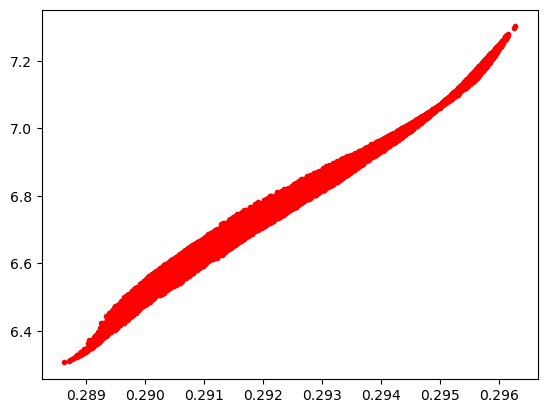

30 : 6.8 : 6.799999999999999
Simulating  30 MV/m, for 9.7
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 9.7 Gun Amp: 30
MEAN Energy: 0.07535900655754028 PLost Fraction: 10000.0 Chirp: 112.18313063564864


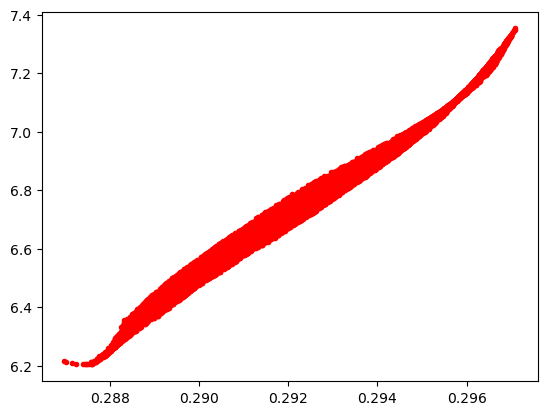

30 : 9.7 : 9.7
Simulating  30 MV/m, for 12.6
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 12.6 Gun Amp: 30
MEAN Energy: 0.07576437101877344 PLost Fraction: 10000.0 Chirp: 105.97536859326584


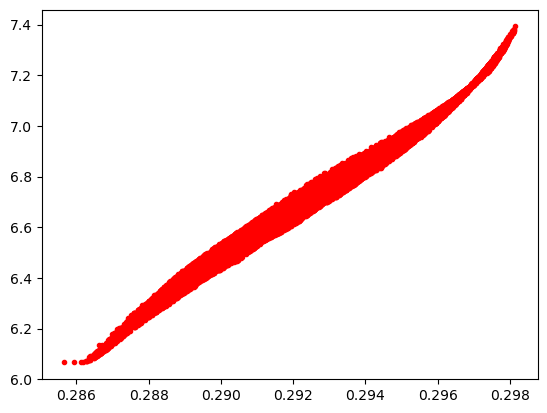

30 : 12.6 : 12.600000000000001
Simulating  30 MV/m, for 15.5
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 15.5 Gun Amp: 30
MEAN Energy: 0.07627050604819965 PLost Fraction: 10000.0 Chirp: 103.68302544345312


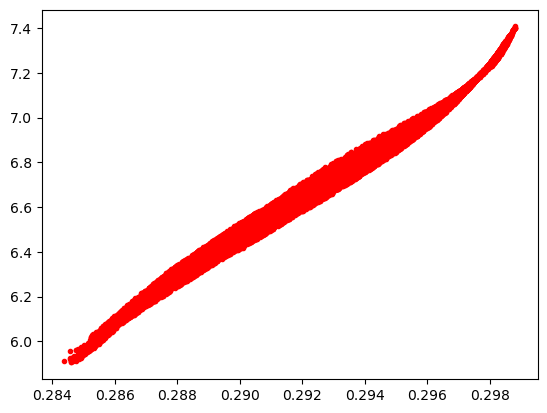

30 : 15.5 : 15.5
Simulating  30 MV/m, for 18.4
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 18.4 Gun Amp: 30
MEAN Energy: 0.07693860416434267 PLost Fraction: 9953.0 Chirp: 98.3673945066331


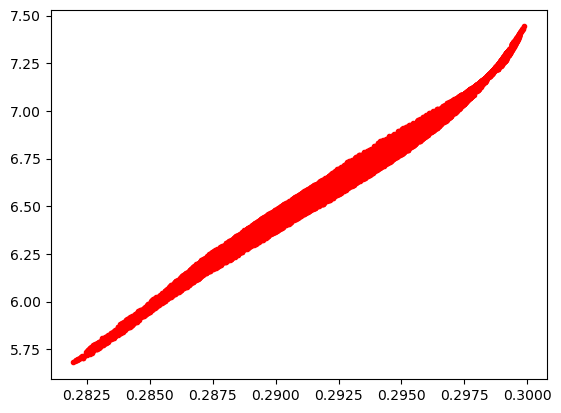

30 : 18.4 : 18.31352
Simulating  30 MV/m, for 21.3
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 21.3 Gun Amp: 30
MEAN Energy: 0.0772005067072259 PLost Fraction: 9209.0 Chirp: 100.56869564040421


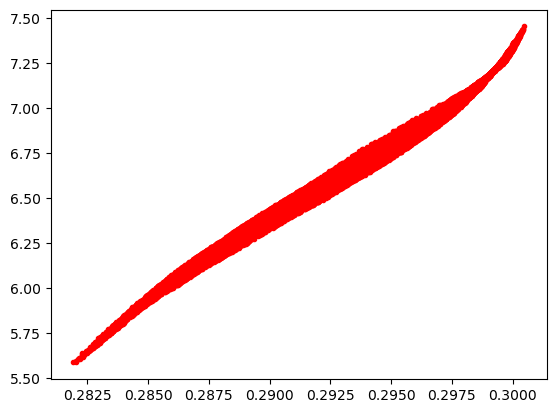

30 : 21.3 : 19.61517
Simulating  30 MV/m, for 24.2
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 24.2 Gun Amp: 30
MEAN Energy: 0.0770805948579623 PLost Fraction: 8087.0 Chirp: 100.21622216755331


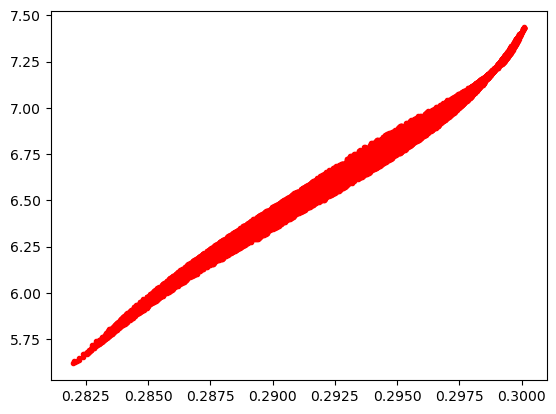

30 : 24.2 : 19.57054
Simulating  30 MV/m, for 27.099999999999998
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 27.099999999999998 Gun Amp: 30
MEAN Energy: 0.07699182989595843 PLost Fraction: 7203.0 Chirp: 100.33097355141231


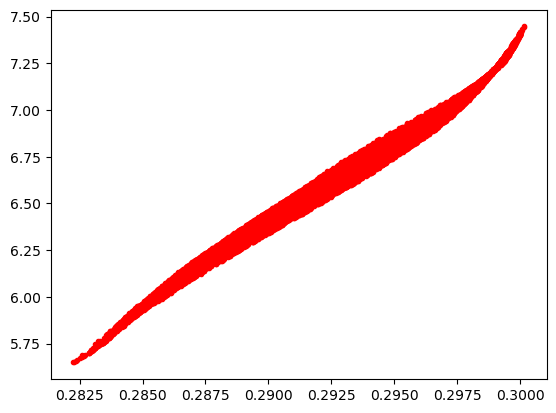

30 : 27.099999999999998 : 19.520129999999998
Simulating  30 MV/m, for 30.0
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 30.0 Gun Amp: 30
MEAN Energy: 0.0770862945090466 PLost Fraction: 6663.0 Chirp: 102.04006315991752


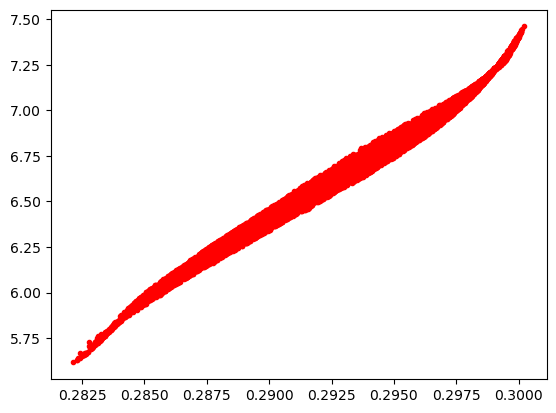

30 : 30.0 : 19.989
Simulating  40 MV/m, for 1.0
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 1.0 Gun Amp: 40
MEAN Energy: 0.056510775844614225 PLost Fraction: 10000.0 Chirp: 110.11526632430518


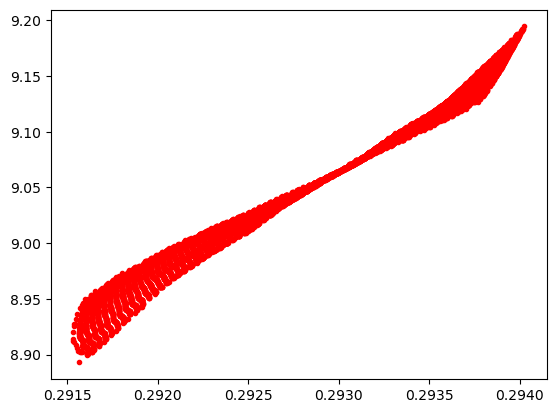

40 : 1.0 : 1.0
Simulating  40 MV/m, for 3.9
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 3.9 Gun Amp: 40
MEAN Energy: 0.05656024675016541 PLost Fraction: 10000.0 Chirp: 180.20504951012708


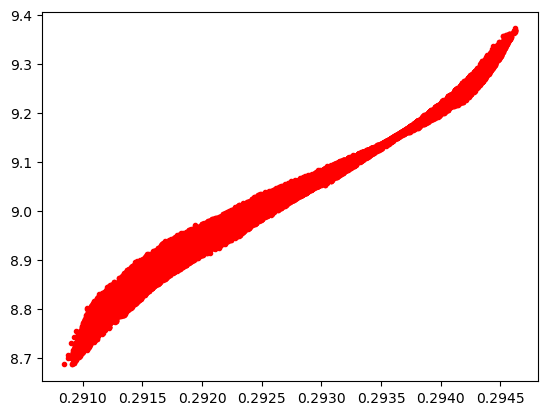

40 : 3.9 : 3.9000000000000004
Simulating  40 MV/m, for 6.8
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 6.8 Gun Amp: 40
MEAN Energy: 0.05661560801113331 PLost Fraction: 10000.0 Chirp: 177.35651461566022


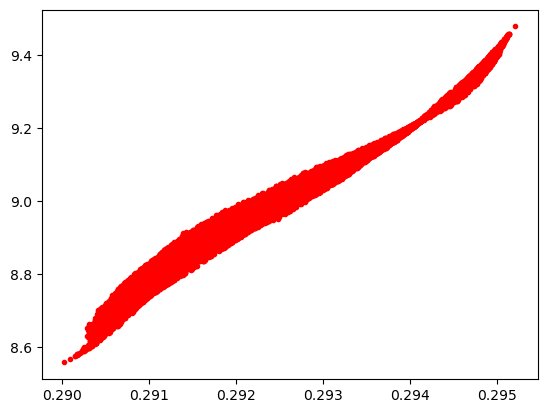

40 : 6.8 : 6.799999999999999
Simulating  40 MV/m, for 9.7
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 9.7 Gun Amp: 40
MEAN Energy: 0.056686862587566805 PLost Fraction: 10000.0 Chirp: 168.54522549210148


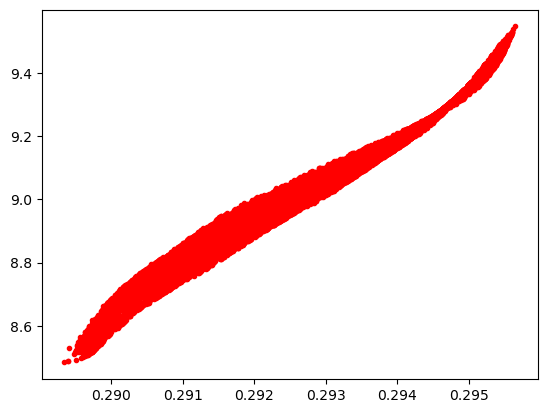

40 : 9.7 : 9.7
Simulating  40 MV/m, for 12.6
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 12.6 Gun Amp: 40
MEAN Energy: 0.05677161198406422 PLost Fraction: 10000.0 Chirp: 150.40816553400734


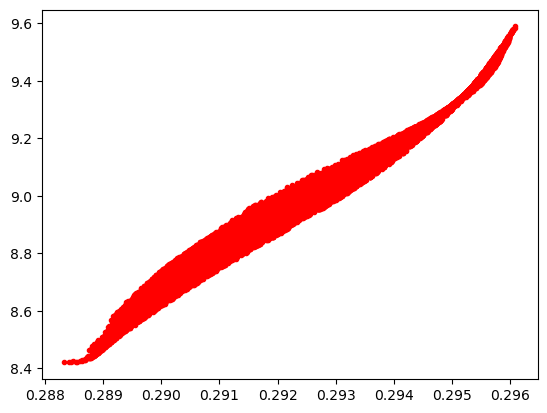

40 : 12.6 : 12.600000000000001
Simulating  40 MV/m, for 15.5
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 15.5 Gun Amp: 40
MEAN Energy: 0.05688488016876621 PLost Fraction: 10000.0 Chirp: 143.0524126667589


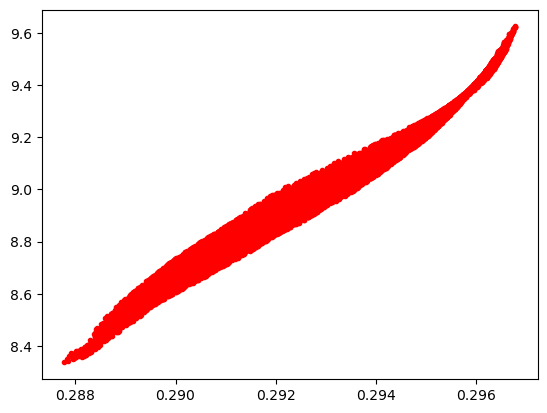

40 : 15.5 : 15.5
Simulating  40 MV/m, for 18.4
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 18.4 Gun Amp: 40
MEAN Energy: 0.057021234228967495 PLost Fraction: 10000.0 Chirp: 124.45809800138052


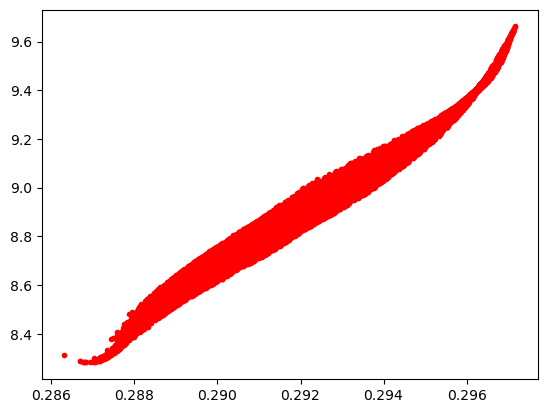

40 : 18.4 : 18.4
Simulating  40 MV/m, for 21.3
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 21.3 Gun Amp: 40
MEAN Energy: 0.0571883233944185 PLost Fraction: 10000.0 Chirp: 125.35329751249212


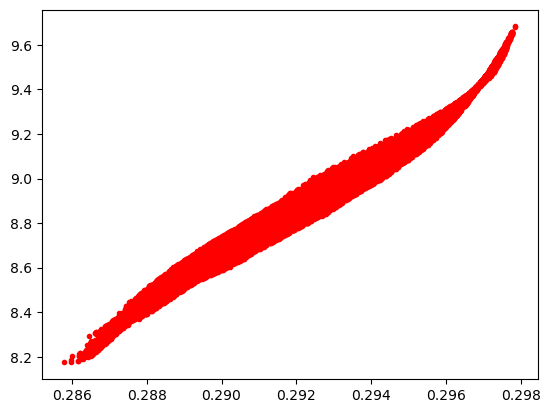

40 : 21.3 : 21.3
Simulating  40 MV/m, for 24.2
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 24.2 Gun Amp: 40
MEAN Energy: 0.05739363851396147 PLost Fraction: 9993.0 Chirp: 119.97872525212354


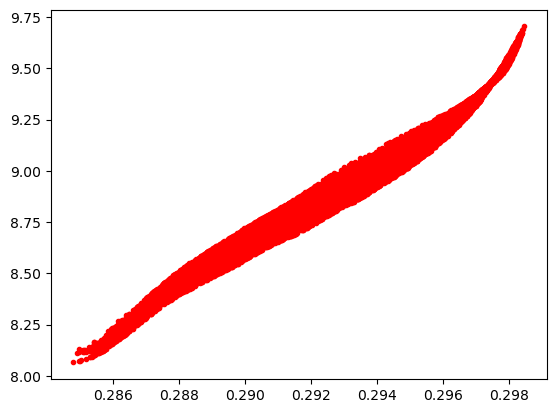

40 : 24.2 : 24.18306
Simulating  40 MV/m, for 27.099999999999998
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 27.099999999999998 Gun Amp: 40
MEAN Energy: 0.05757077613138605 PLost Fraction: 9724.0 Chirp: 118.23055388217448


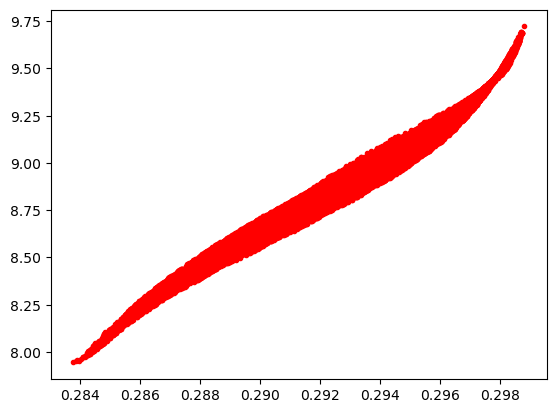

40 : 27.099999999999998 : 26.352039999999995
Simulating  40 MV/m, for 30.0
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 30.0 Gun Amp: 40
MEAN Energy: 0.05757932164684641 PLost Fraction: 8930.0 Chirp: 120.49363207683793


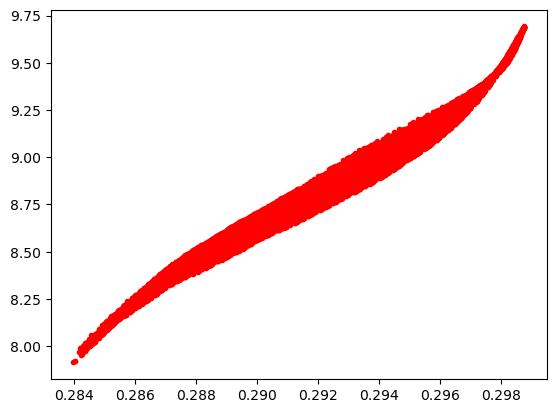

40 : 30.0 : 26.790000000000003
Simulating  50 MV/m, for 1.0
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 1.0 Gun Amp: 50
MEAN Energy: 0.045778196864577 PLost Fraction: 10000.0 Chirp: 94.06701106126397


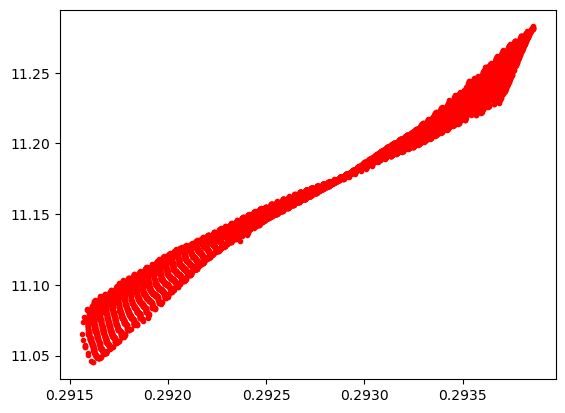

50 : 1.0 : 1.0
Simulating  50 MV/m, for 3.9
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 3.9 Gun Amp: 50
MEAN Energy: 0.0457851521844166 PLost Fraction: 10000.0 Chirp: 193.45877399237494


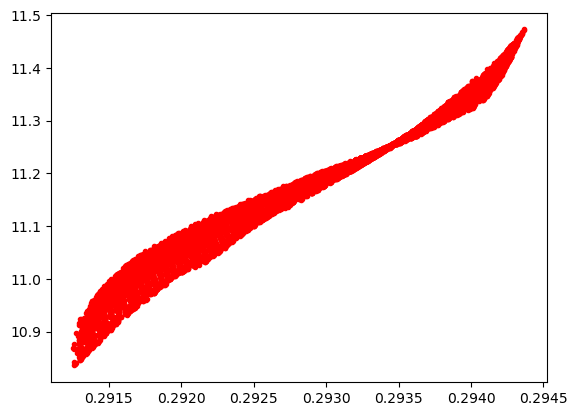

50 : 3.9 : 3.9000000000000004
Simulating  50 MV/m, for 6.8
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 6.8 Gun Amp: 50
MEAN Energy: 0.045791982601226904 PLost Fraction: 10000.0 Chirp: 217.3246276345248


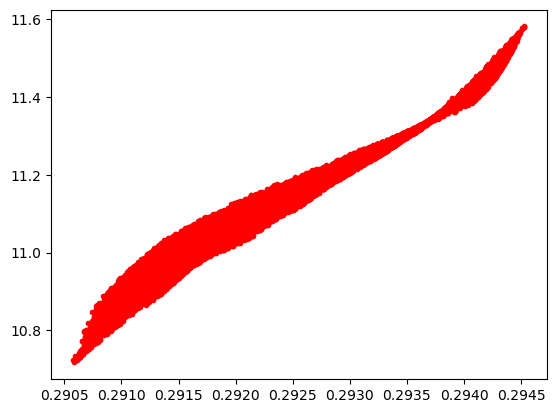

50 : 6.8 : 6.799999999999999
Simulating  50 MV/m, for 9.7
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 9.7 Gun Amp: 50
MEAN Energy: 0.045805191144734206 PLost Fraction: 10000.0 Chirp: 209.757598271936


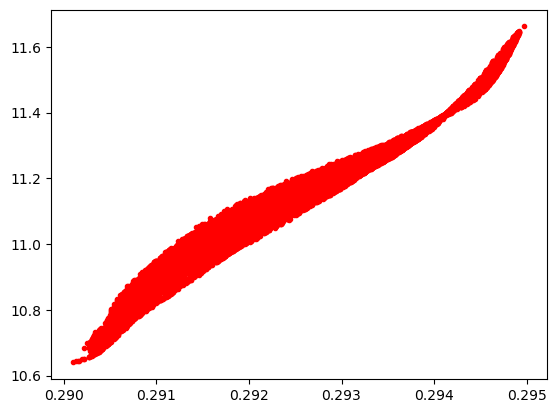

50 : 9.7 : 9.7
Simulating  50 MV/m, for 12.6
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 12.6 Gun Amp: 50
MEAN Energy: 0.04582424105378053 PLost Fraction: 10000.0 Chirp: 201.77076254989646


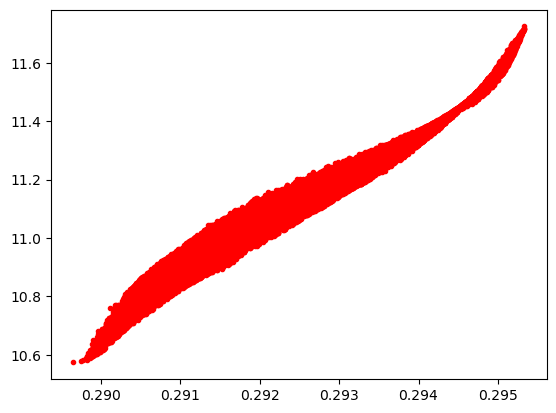

50 : 12.6 : 12.600000000000001
Simulating  50 MV/m, for 15.5
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 15.5 Gun Amp: 50
MEAN Energy: 0.045851904900374794 PLost Fraction: 10000.0 Chirp: 193.6655740374069


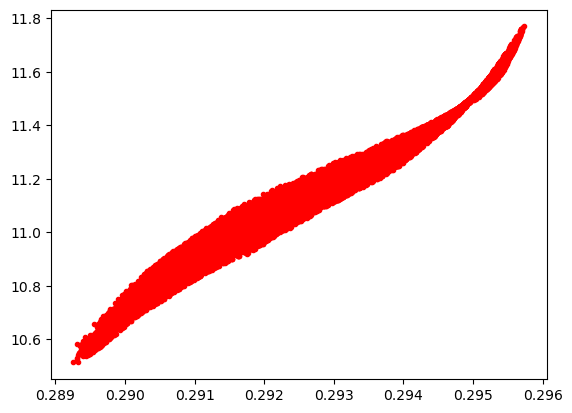

50 : 15.5 : 15.5
Simulating  50 MV/m, for 18.4
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 18.4 Gun Amp: 50
MEAN Energy: 0.045884409549166866 PLost Fraction: 10000.0 Chirp: 175.32145618620854


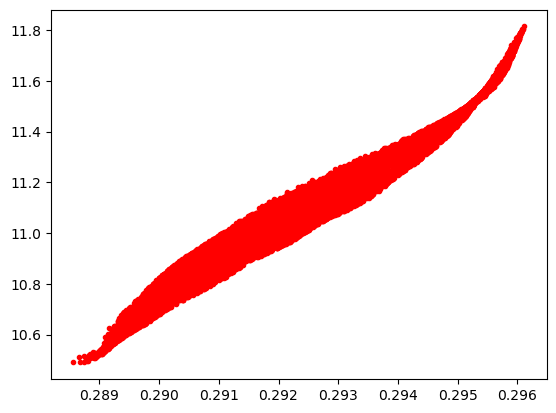

50 : 18.4 : 18.4
Simulating  50 MV/m, for 21.3
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 21.3 Gun Amp: 50
MEAN Energy: 0.045932181709677784 PLost Fraction: 10000.0 Chirp: 153.486695597281


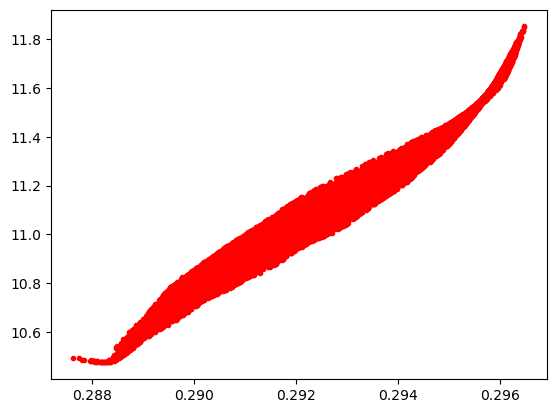

50 : 21.3 : 21.3
Simulating  50 MV/m, for 24.2
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 24.2 Gun Amp: 50
MEAN Energy: 0.045987381033018235 PLost Fraction: 10000.0 Chirp: 149.07769842717624


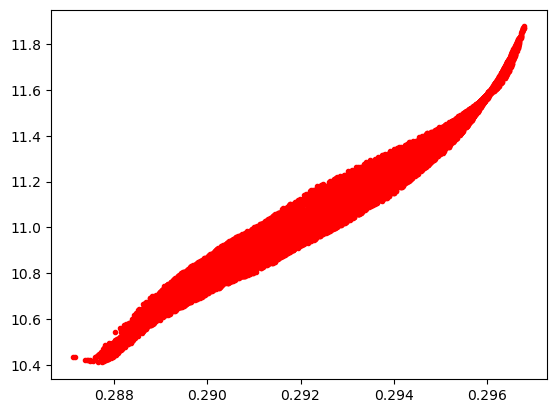

50 : 24.2 : 24.2
Simulating  50 MV/m, for 27.099999999999998
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 27.099999999999998 Gun Amp: 50
MEAN Energy: 0.046059434413588306 PLost Fraction: 10000.0 Chirp: 133.07968573673534


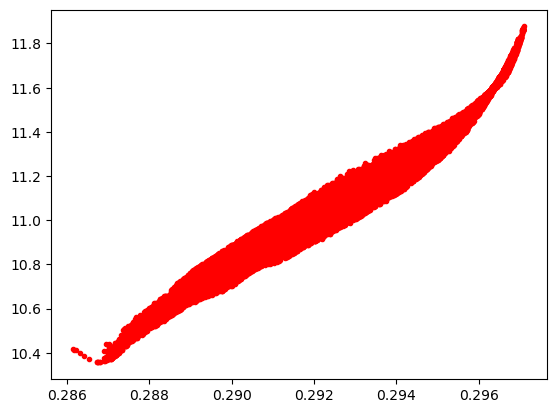

50 : 27.099999999999998 : 27.099999999999994
Simulating  50 MV/m, for 30.0
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 30.0 Gun Amp: 50
MEAN Energy: 0.04615193796197849 PLost Fraction: 9998.0 Chirp: 133.92205172887805


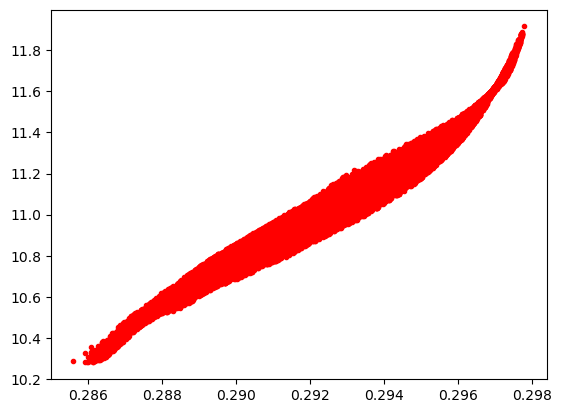

50 : 30.0 : 29.994000000000003
Simulating  80 MV/m, for 1.0
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 1.0 Gun Amp: 80
MEAN Energy: 0.029432059142845995 PLost Fraction: 10000.0 Chirp: 49.39155194708196


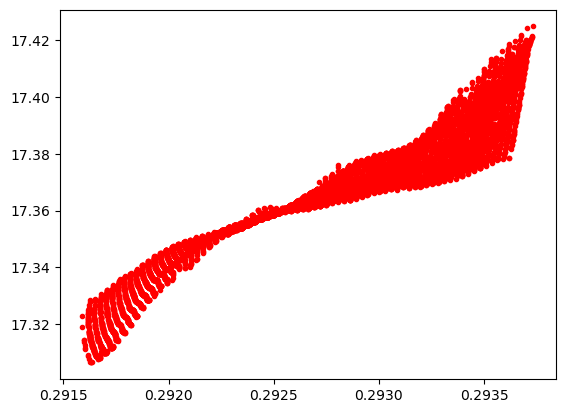

80 : 1.0 : 1.0
Simulating  80 MV/m, for 3.9
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 3.9 Gun Amp: 80
MEAN Energy: 0.02942324488731418 PLost Fraction: 10000.0 Chirp: 176.04733470911762


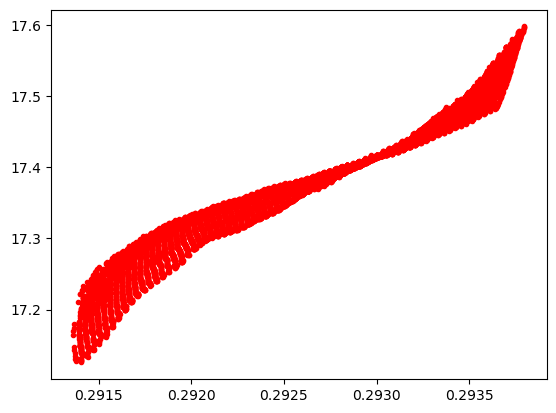

80 : 3.9 : 3.9000000000000004
Simulating  80 MV/m, for 6.8
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 6.8 Gun Amp: 80
MEAN Energy: 0.02941298890417025 PLost Fraction: 10000.0 Chirp: 272.2039777165743


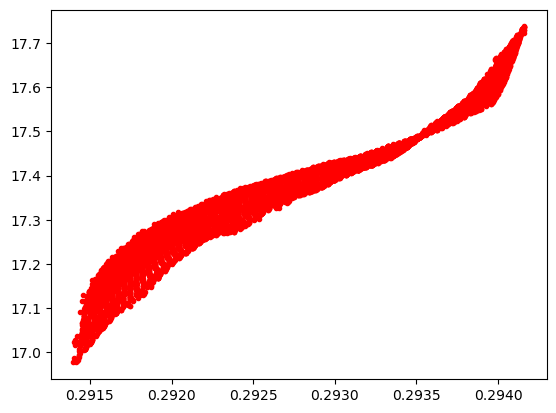

80 : 6.8 : 6.799999999999999
Simulating  80 MV/m, for 9.7
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 9.7 Gun Amp: 80
MEAN Energy: 0.02940238148838245 PLost Fraction: 10000.0 Chirp: 305.75247087645823


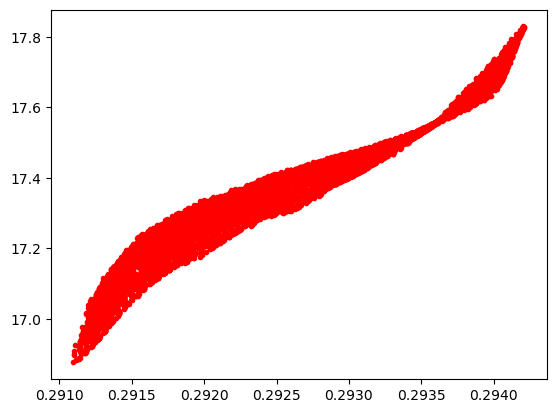

80 : 9.7 : 9.7
Simulating  80 MV/m, for 12.6
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 12.6 Gun Amp: 80
MEAN Energy: 0.029393083111248337 PLost Fraction: 10000.0 Chirp: 322.5686796343954


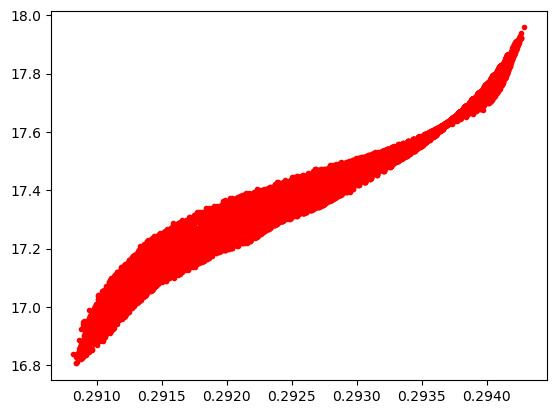

80 : 12.6 : 12.600000000000001
Simulating  80 MV/m, for 15.5
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 15.5 Gun Amp: 80
MEAN Energy: 0.029384345003567184 PLost Fraction: 10000.0 Chirp: 327.8768376196634


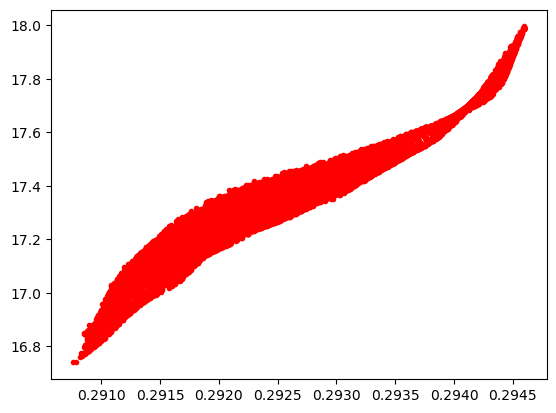

80 : 15.5 : 15.5
Simulating  80 MV/m, for 18.4
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 18.4 Gun Amp: 80
MEAN Energy: 0.02937678553008702 PLost Fraction: 10000.0 Chirp: 329.4609105446132


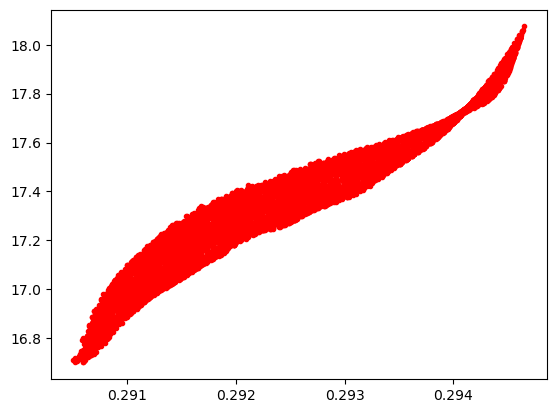

80 : 18.4 : 18.4
Simulating  80 MV/m, for 21.3
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 21.3 Gun Amp: 80
MEAN Energy: 0.0293709528090905 PLost Fraction: 10000.0 Chirp: 316.170923002402


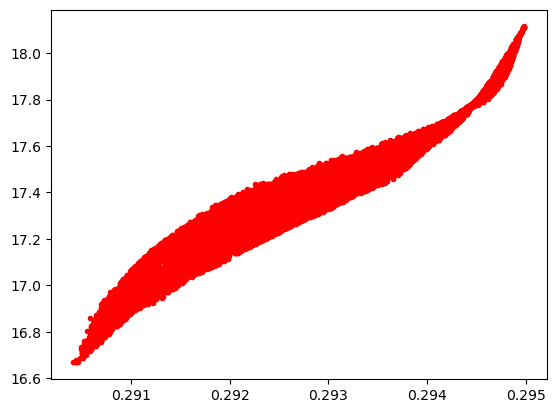

80 : 21.3 : 21.3
Simulating  80 MV/m, for 24.2
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 24.2 Gun Amp: 80
MEAN Energy: 0.029366252516345896 PLost Fraction: 10000.0 Chirp: 317.7513489712658


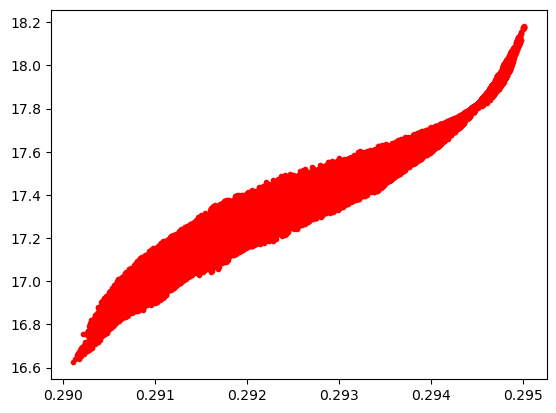

80 : 24.2 : 24.2
Simulating  80 MV/m, for 27.099999999999998
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 27.099999999999998 Gun Amp: 80
MEAN Energy: 0.029363164250846216 PLost Fraction: 10000.0 Chirp: 284.490255688532


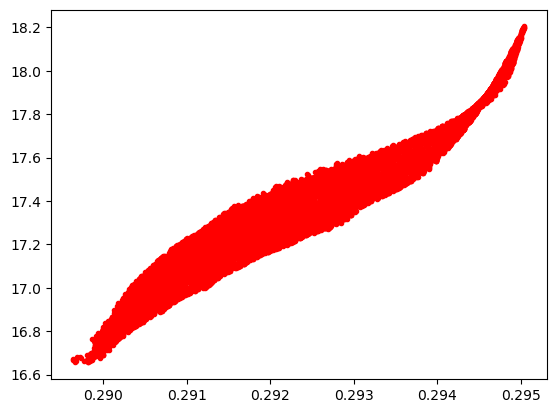

80 : 27.099999999999998 : 27.099999999999994
Simulating  80 MV/m, for 30.0
CURRENT FUNC EVAL
Gun Phase: 140.0 LINAC Phases: [] Charge: 30.0 Gun Amp: 80
MEAN Energy: 0.029361536034753315 PLost Fraction: 10000.0 Chirp: 257.9129920881105


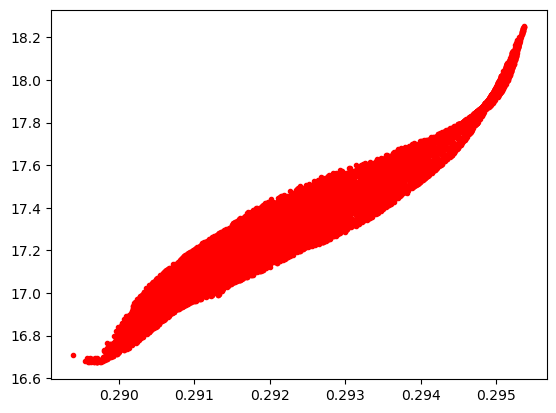

80 : 30.0 : 30.0


In [28]:
charge = np.linspace(1,30,11)
gradients = np.array([20,30,40,50,80])#,40]) #,60,70])
ds_charge = np.zeros([len(gradients),len(charge)])
gun_phase = 140

ds_charge2 = np.zeros(np.shape(ds_charge))
ds_charge2[:] = ds_charge[:]

Lx = 1e-2
Ly = 1e-2
Lz = 3.17203e-06
#linesplit_list[1][2] = str(1)

for i in range(len(gradients)):
    for j in range(len(charge)):
        with open("Input/ImpactT.in",'r') as fin:
            lines = fin.readlines()
            linesplit_list = []
            for line in lines:
                if line.split()[0] == '!' or line.split()[0][0] == '!':
                    continue
                else:
                    linesplit_list.append(line.split())
            gun_phase, linac_phases, sol_strengths = read_phases(linesplit_list)
            linesplit_list[0][0] = str(Ncols)
            linesplit_list[0][1] = str(Nrows)
            Nbunch = int(linesplit_list[1][-1])
            linesplit_list[2][1] = str(int(1e4*charge[j]))
        
        plt.figure()
        define_part(Nbunch,charge[j],Lx,Ly,Lz)
        linesplit_list[2][1] = str(int(1e4))
        print("Simulating ", gradients[i], "MV/m, for", charge[j])
        out = {}
        problem._evaluate([140.0,charge[j],gradients[i]],out)
        for n in range(Nbunch):
            LPS = np.loadtxt("MaximizeLPSMomentumYAG4/fort.5"+str(n))
            plt.plot(LPS[:,-2],LPS[:,-1],'r.')
            if np.isnan(LPS).any():
                ds_charge[i,j] += 0
            else:
                ds_charge[i,j] += len(LPS)
        plt.show()
        ds_charge[i,j] /= 1e4/charge[j]
        print(gradients[i],":",charge[j],":",ds_charge[i,j])

In [ ]:
ds_charge[:-1,:] = ds_charge2[:,:]

NameError: name 'ds_charge2' is not defined

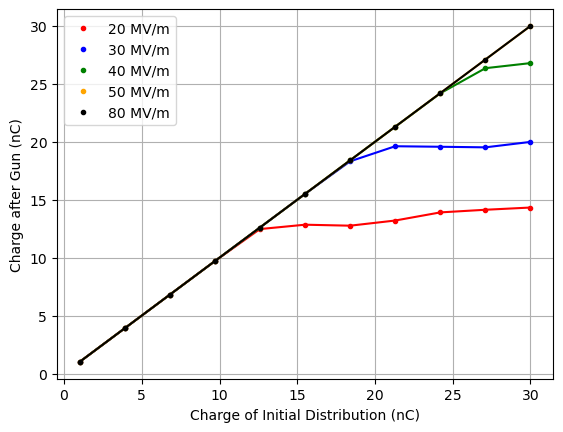

In [35]:
plt.plot(charge,ds_charge[0],color='red')
plt.plot(charge,ds_charge[0],'.',label='20 MV/m',color='red')
plt.plot(charge,ds_charge[1],color='blue')
plt.plot(charge,ds_charge[1],'.',label='30 MV/m',color='blue')
plt.plot(charge,ds_charge[2],color='green')
plt.plot(charge,ds_charge[2],'.',label='40 MV/m',color='green')
plt.plot(charge,ds_charge[3],color='orange')
plt.plot(charge,ds_charge[3],'.',label='50 MV/m',color='orange')
plt.plot(charge,ds_charge[4],color='black')
plt.plot(charge,ds_charge[4],'.',label='80 MV/m',color='black')
plt.grid()
plt.xlabel(r"Charge of Initial Distribution (nC)")
plt.ylabel(r"Charge after Gun (nC)")
plt.legend()
plt.savefig('50deg_curves_low_grad.png')